# Mini-projets UE14 Mines ParisTech 2021 S17 et S18
Ce notebook contient les informations et les données nécessaires aux calculs proposés dans les sujets 18 et 19 des mini-projets de l'UE14 2021.

Liens vers les descriptions:
- Sujet 17 "Comment l’empreinte carbone des pays est-elle calculée ?" https://docs.google.com/document/d/1GijTxGaNKpwpeuGNfZtfMtOGAOAMh2EOAmpkwYa-2fw/edit
- Sujet 18 "Réconcilier les méthodes de calcul d’empreinte carbone" https://docs.google.com/document/d/19Fh1tyZqaGFunaKeC_HXfsHgXBtz8TAHyeoS2fcGRxE/edit

Pour toute question: <thomas.gibon@list.lu>

Ce dont vous aurez besoin pour ce mini-projet:

1. l'installation de la distribution Anaconda (ou Miniconda), qui contient déjà tous les modules Python de base pour les calculs (numpy, pandas, ...), les instructions d'installation sont disponibles [ici](https://docs.anaconda.com/anaconda/install/index.html).

2. un environnement `conda` dédié au projet (pas nécessaire, mais recommandé) en procédant ainsi:
    - ouvrir un terminal (`cmd` sous Windows),
    - créer l'environnement en ligne de commande `conda create -n io`,
    - activer l'environnement `activate io`
    
3. installer `pymrio` à partir de https://anaconda.org/conda-forge/pymrio
    - en ligne de commande, s'assurer que l'environnement `io` est activé
    - installer le package `conda install -c conda-forge pymrio`

In [1]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

## Télécharger la base de données EXIOBASE
La première chose à faire est de récupérer la ou les tables input-output EXIOBASE, à partir du dernier dépôt Zenodo.
Une fois les données téléchargées, les importer, et vous êtes prêts à les utiliser.

In [3]:
doi = '10.5281/zenodo.5589597'

Choisir le répertoire d'installation.

In [4]:
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

In [5]:
year = 2019
filename = EXIOBASE_PATH+'IOT_{}_ixi.zip'.format(year)

Lancer le téléchargement avec la commande dédiée.

Attention, les données sont volumineuses, si vous avez déjà téléchargé une fois, il est inutile de recommencer. Préférer le réseau de l'école si possible (sauf si vous avez la fibre...).

In [6]:
if not os.path.isfile(filename):
    exio_meta = mr.download_exiobase3(
        storage_folder=EXIOBASE_PATH, # chemin d'installation
        system='ixi',                 # choisir table produit-par-produit (pxp) ou industrie-par-industrie (ixi)
        years=year,     # quelles années télécharger
        doi=doi                       # adresse du dépôt
    )

Une fois les fichiers téléchargés, il reste à importer la base de données `pymrio`. Choisir une année en particulier (2019 est recommandé).

In [7]:
io = mr.parse_exiobase3(path=filename)

Importer le fichier de population (intéressant pour calculer les empreintes par personne)

In [8]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

Enfin, le système doit être "calculé", pour déterminer, entre autres, les résultats d'empreinte environnementale. 

In [9]:
io.calc_all()

C:\Users\Gibon\.conda\envs\io\lib\site-packages\pymrio\core\mriosystem.py:878: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  Y_agg = Y.sum(level="region", axis=1).reindex(
C:\Users\Gibon\.conda\envs\io\lib\site-packages\pymrio\core\mriosystem.py:928: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  F_Y_agg = self.F_Y.sum(level="region", axis=1).reindex(


## Familiarisation avec la structure
L'objet créé `io` contient toute la structure de la table input-output multirégionale, c'est-à-dire la table complète des coefficients/transactions monétaires entre secteurs et pays. Ce sont ces coefficients qui vont nous permettre de retracer les émissions de GES entre production et consommation.

Un coefficient $a_{ij}$ représente toujours une transaction du secteur i vers le secteur j. Tout vecteur colonne représente donc l'ensemble des intrants pour un secteur donné (comme une recette de cuisine donne les ingrédients).

**Toutes les matrices monétaires sont organisées de la même façon, avec un index (pays, secteur) pour les lignes et les colonnes, en M€ ou M€/M€. Les matrices contenant les émissions ont simplement une liste d'émissions en ligne, et (pays, secteur) en colonne.**

### Pays et régions
EXIOBASE contient les données de 49 zones géographiques, dont l'UE 27+1 en début de liste et 5 zones "reste" (`W...`) en fin de liste (Asie, Amérique Latine, Europe, Afrique, monde).

In [10]:
io.get_regions()

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO',
       'SE', 'SI', 'SK', 'GB', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX',
       'RU', 'AU', 'CH', 'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF',
       'WM'],
      dtype='object', name='region')

### Secteurs
163 secteurs industriels sont disponibles. Les tableaux entrées-sorties ont donc une taille de $(49 × 163) × (49 × 163) = 7987 × 7987$.

In [11]:
list(io.get_sectors())

['Cultivation of paddy rice',
 'Cultivation of wheat',
 'Cultivation of cereal grains nec',
 'Cultivation of vegetables, fruit, nuts',
 'Cultivation of oil seeds',
 'Cultivation of sugar cane, sugar beet',
 'Cultivation of plant-based fibers',
 'Cultivation of crops nec',
 'Cattle farming',
 'Pigs farming',
 'Poultry farming',
 'Meat animals nec',
 'Animal products nec',
 'Raw milk',
 'Wool, silk-worm cocoons',
 'Manure treatment (conventional), storage and land application',
 'Manure treatment (biogas), storage and land application',
 'Forestry, logging and related service activities (02)',
 'Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)',
 'Mining of coal and lignite; extraction of peat (10)',
 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
 'Extraction of natural gas and services related to natural gas extraction, excluding surveying',
 'Extraction, liquefaction, and regasificat

In [12]:
io.Z.shape

(7987, 7987)

### Z: consommation intermédiaire
Cette matrice présente la consommation intermédiaire complète entre secteurs, en M€.

Par exemple: le secteur de l'élevage bovin français a dépensé 1214 M€ en produits cultivés (non-blé, non-riz) en 2019, ainsi que 710 M€ en produits de gros, 580 M€ en produits de l'industrie agro-alimentaire, etc. À noter, 258 M€ de produits cultivés ont été importés de la région "reste de l'Afrique" (`WF`).

In [13]:
io.Z.head()

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                                      0   
       Cultivation of wheat                                           0   
       Cultivation of cereal grains nec                               0   
       Cultivation of vegetables, fruit, nuts                         0   
       Cultivation of oil seeds                                       0   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                              12.533904   
       Cultivation of cereal grains nec                   0.000000   
       Cultivation of vegetables, fruit, nuts             0.000000   
       Cultivation of oil seeds                           0.000000   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.000000   
       Cultivation of cereal grains nec                              12.825861   
       Cultivation of vegetables, fruit, nuts                         0.000000   
       Cultivation of oil seeds                                       0.000000   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                            0.000000   
       Cultivation of wheat                                                 0.000000   
       Cultivation of cereal grains nec                                     0.000000   
       Cultivation of vegetables, fruit, nuts                             113.553421   
       Cultivation of oil seeds                                             0.000000   

region                                                                  \
sector                                        Cultivation of oil seeds   
region sector                                                            
AT     Cultivation of paddy rice                              0.000000   
       Cultivation of wheat                                   0.000000   
       Cultivation of cereal grains nec                       0.000000   
       Cultivation of vegetables, fruit, nuts                 0.000000   
       Cultivation of oil seeds                               0.532914   

region                                                                               \
sector                                        Cultivation of sugar cane, sugar beet   
region sector                                                                         
AT     Cultivation of paddy rice                                                0.0   
       Cultivation of wheat                                                     0.0   
       Cultivation of cereal grains nec                                         0.0   
       Cultivation of vegetables, fruit, nuts                                   0.0   
       Cultivation of oil seeds                                                 0.0   

region                                                                           \
sector                                        Cultivation of plant-based fibers   
region sector       

In [14]:
io.x.loc['FR','Cattle farming']

indout    7535.532131
Name: (FR, Cattle farming), dtype: float64

In [15]:
io.Z['FR','Cattle farming'].sort_values(ascending=False).head(8)

region  sector                                                                                             
FR      Cultivation of crops nec                                                                               1213.973491
        Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)                     709.813893
        Processing of Food products nec                                                                         581.217679
        Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)     501.188476
        Cultivation of cereal grains nec                                                                        384.730878
        Manufacture of beverages                                                                                277.375923
WF      Cultivation of crops nec                                                                                257.778025
FR      Cultivation of wheat   

### A: coefficients de consommation intermédiaire
La matrice `A` contient les coefficients de consommation intermédiaire, en €/€.

Par exemple, quels sont les trois secteurs principaux composant les dépenses du secteur de l'électricité au gaz en France en 2019?

In [16]:
io.A['FR','Production of electricity by gas'].sort_values(ascending=False).head(3)

region  sector                                                                                       
FR      Manufacture of gas; distribution of gaseous fuels through mains                                  0.525974
NO      Extraction of natural gas and services related to natural gas extraction, excluding surveying    0.186255
DE      Extraction of natural gas and services related to natural gas extraction, excluding surveying    0.139489
Name: (FR, Production of electricity by gas), dtype: float64

Interprétation : pour fournir 1€ d'électricité au gaz à l'économie, les coûts sont de :
- 0.53€ en raffinage, transmission et distribution, en France,
- 0.19€ de gaz importé de Norvège,
- 0.14€ de gaz importé d'Allemagne.

De la même façon, on peut déterminer quels secteurs ont l'électricité au gaz française parmi leurs intrants principaux. Sans surprise, cela devrait être la transmission et la distribution d'électricité.

In [17]:
io.A.loc['FR','Production of electricity by gas'].sort_values(ascending=False).head(3)

region  sector                                             
FR      Distribution and trade of electricity                  0.075094
        Transmission of electricity                            0.073398
        Recreational, cultural and sporting activities (92)    0.006013
Name: (FR, Production of electricity by gas), dtype: float64

### Y: demande finale
La demande finale contient les informations de consommation finale des ménages, des ONGs, et du gouvernement, ainsi que les changements d'inventaire ou la consommation de capital.

Par exemple, quels sont les secteurs de dépense principaux des ménages allemands ?

In [18]:
io.Y['DE'].columns

Index(['Final consumption expenditure by households',
       'Final consumption expenditure by non-profit organisations serving households (NPISH)',
       'Final consumption expenditure by government',
       'Gross fixed capital formation', 'Changes in inventories',
       'Changes in valuables', 'Exports: Total (fob)'],
      dtype='object', name='category')

In [19]:
io.Y['DE','Final consumption expenditure by households'].sort_values(ascending=False).head()

region  sector                                                             
DE      Real estate activities (70)                                            343369.173295
        Hotels and restaurants (55)                                            108577.573264
        Post and telecommunications (64)                                        89473.932576
        Financial intermediation, except insurance and pension funding (65)     65978.802344
        Health and social work (85)                                             65977.997346
Name: (DE, Final consumption expenditure by households), dtype: float64

Interprétation : en 2019 les ménages allemands ont dépensé 343 milliards d'euros dans le marché de l'immobilier, 109 G€ en hotels et restaurants, 89 G€ en frais de télécommunication divers, etc.

In [20]:
io.Z['DE','Real estate activities (70)'].sort_values(ascending=False).head()

region  sector                                                             
DE      Construction (45)                                                      27154.163819
        Other business activities (74)                                         21791.224626
        Financial intermediation, except insurance and pension funding (65)    21378.019177
        Real estate activities (70)                                            18585.367612
        Distribution and trade of electricity                                   1089.769773
Name: (DE, Real estate activities (70)), dtype: float64

### L: coefficients directs et indirects (inverse de Leontief)
Cette matrice est la clé de voûte de tout le système entrée-sortie. Son développeur, Wassily Leontief, s'est vu [décerner le "prix Nobel" d'économie en 1973](https://www.economie.gouv.fr/facileco/wassily-leontief).

La principale propriété de cette matrice, c'est qu'elle donne non seulement les coefficients d'"input" directs pour une industrie, par exemple le béton pour la construction, mais aussi la somme de la demande en béton nécessaire aux autres inputs de la construction, et celle des inputs des inputs, etc. couvrant ainsi la totalité de la demande en béton directe et indirecte pour satisfaire la demande de construction.

Illustrons cet exemple par le calcul:

In [21]:
index=((slice(None),'Manufacture of cement, lime and plaster'),
         ('FR','Construction (45)'))

In [22]:
# facteurs directs
direct = io.A.loc[index].sort_values(ascending=False).head()

In [23]:
# facteurs directs ET indirects
direct_indirect = io.L.loc[index].sort_values(ascending=False).head()

In [24]:
# calculons la différence
indirect = (direct_indirect - direct)

<AxesSubplot:xlabel='region'>

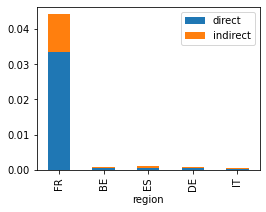

In [25]:
pd.concat([direct,indirect],axis=1,keys=('direct','indirect')).sort_values(by='direct',ascending=False).head().droplevel(1).plot(kind='bar',stacked=True,figsize=(4,3))

Interprétation : le secteur de la construction en France requiert un peu plus de 0.03€ de ciment (FR) par € fourni à l'économie, mais plus de 0.04€ en incluant le ciment nécessaire à tous les autres secteurs requis pour la construction.

### Matrices "satellites"
Les matrices satellites sont les homologues de Z et A, mais en termes de facteurs de production, de valeur ajoutée, et d'émissions de substances.

#### F: facteurs de production
Les facteurs de production sont simplement les "ressources primaires" (capital, emploi, ressources naturelles, émissions de substances). Cette matrice constitue l'interface entre l'économie et le reste de l'environnement.

On peut y trouver les informations sur les salaires, par exemple la masse salariale du secteur de la santé au Royaume-Uni se composait de 4.6/59/89 milliards d'euros en emplois non-qualifiés/intermédiaires/qualifiés en 2019. Ce secteur a par ailleurs émis 2.2 millions de tonnes de CO2 (en émissions directes dues à la combustion de carburants fossiles).

In [26]:
io.satellite.F['GB','Health and social work (85)'].head()

stressor
Taxes less subsidies on products purchased: Total                                                 6359.466983
Other net taxes on production                                                                      373.229764
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled        4589.108985
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled    59381.604405
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled      89403.465875
Name: (GB, Health and social work (85)), dtype: float64

In [27]:
list(io.satellite.F.index)

['Taxes less subsidies on products purchased: Total',
 'Other net taxes on production',
 "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",
 "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",
 "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled",
 'Operating surplus: Consumption of fixed capital',
 'Operating surplus: Rents on land',
 'Operating surplus: Royalties on resources',
 'Operating surplus: Remaining net operating surplus',
 'Employment: Low-skilled male',
 'Employment: Low-skilled female',
 'Employment: Medium-skilled male',
 'Employment: Medium-skilled female',
 'Employment: High-skilled male',
 'Employment: High-skilled female',
 'Employment hours: Low-skilled male',
 'Employment hours: Low-skilled female',
 'Employment hours: Medium-skilled male',
 'Employment hours: Medium-skilled female',
 'Employment hours: High-skilled male',
 'Employment ho

In [28]:
io.satellite.F.loc['CO2 - combustion - air',('GB','Health and social work (85)')]

2330174931.5

#### S: coefficients
Les coefficients satellites sont l'équivalent de la matrice A pour les facteurs de production. Par exemple, combien de CO2 a été émis pour fournir 1€ de services de santé au Royaume-Uni ?

In [29]:
io.satellite.S.loc['CO2 - combustion - air',('GB','Health and social work (85)')]

6924.79879166

## Calculs d'impact
Les matrices satellite D sont celles qui nous intéressent pour ce projet.

- D_pba: inventaire national (production-based accounts),
- D_cba: empreinte (consumption-based accounts),
- D_imp
- D_exp

Elles se déclinent en
- ..._reg: résultats agrégés au niveau de la région
- ..._cap: résultats par personne

### Émissions territoriales

In [30]:
# D_pba: production-based account
# Cette matrice nous donne tout simplement les facteurs de production, c'est l'équivalent de F

# Émissions directes de CO2 par secteur
io.satellite.D_pba.loc['CO2 - combustion - air']

region  sector                                             
AT      Cultivation of paddy rice                              0.000000e+00
        Cultivation of wheat                                   2.389919e+08
        Cultivation of cereal grains nec                       2.334131e+08
        Cultivation of vegetables, fruit, nuts                 1.054479e+08
        Cultivation of oil seeds                               4.922765e+07
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      2.785854e+08
        Recreational, cultural and sporting activities (92)    5.254490e+08
        Other service activities (93)                          3.912441e+08
        Private households with employed persons (95)          7.076345e+07
        Extra-territorial organizations and bodies             0.000000e+00
Name: CO2 - combustion - air, Length: 7987, dtype: float64

In [31]:
io.satellite.F.loc['CO2 - combustion - air']

region  sector                                             
AT      Cultivation of paddy rice                              0.000000e+00
        Cultivation of wheat                                   2.389919e+08
        Cultivation of cereal grains nec                       2.334131e+08
        Cultivation of vegetables, fruit, nuts                 1.054479e+08
        Cultivation of oil seeds                               4.922765e+07
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      2.785854e+08
        Recreational, cultural and sporting activities (92)    5.254490e+08
        Other service activities (93)                          3.912441e+08
        Private households with employed persons (95)          7.076345e+07
        Extra-territorial organizations and bodies             0.000000e+00
Name: CO2 - combustion - air, Length: 7987, dtype: float64

Affichons les inventaires de CO2 pour tous les pays de la base de données.

<AxesSubplot:ylabel='Émissions de CO2, 2019, Mt'>

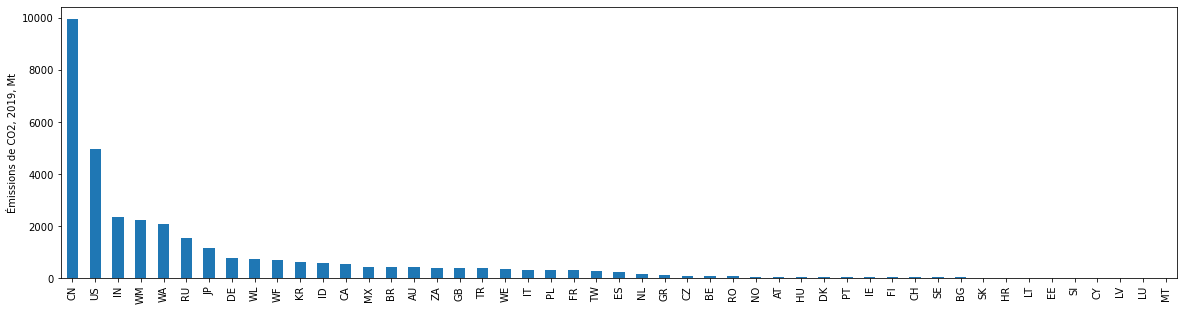

In [32]:
emissions_CO2_inventaire = io.satellite.D_pba_reg.loc['CO2 - combustion - air']*1e-9
emissions_CO2_inventaire.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), ylabel='Émissions de CO2, 2019, Mt')

In [33]:
emissions_CO2_inventaire['FR']

304.87890253300003

La valeur pour la France semble correcte si on est déjà familier avec [les chiffres (305 Mt en 2019)](https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-12/datalab_81_chiffres_cles_du_climat_edition_2021.pdf?page=44).

D'abord il faut considérer les gaz à effet de serre principaux.

In [34]:
GWP_factors_all = pd.read_excel(EXIOBASE_PATH + 'GWP100_EXIOBASE_factors.xlsx',index_col=0,squeeze=True)
GWP_factors_all

,"Climate change, short term (kg CO2 eq (short))",UNFCCC GWP factors IPCC AR4
CO2 - combustion - air,1.00,1
CH4 - combustion - air,36.00,25
N2O - combustion - air,298.00,298
CO - combustion - air,1.57,0
CH4 - non combustion - Extraction/production of (natural) gas - air,36.00,25
...,...,...
Nitrogen fluoride - air - unspecified,17900.00,0
Nitrogen trifluoride - air - unspecified,17900.00,0
"Propane, 1,1,1,3,3,3-hexafluoro-, hcfc-236fa - air - unspecified",9000.00,0
"Propane, perfluoro- - air - unspecified",9880.00,0


In [35]:
GWP_factors_all = pd.read_excel(EXIOBASE_PATH + 'GWP100_EXIOBASE_factors.xlsx',index_col=0,squeeze=True)['UNFCCC GWP factors IPCC AR4']
GWP_factors = GWP_factors_all[['CO2 - combustion - air',
                               'CH4 - combustion - air',
#                                'N2O - combustion - air',
                               'CO2 - non combustion - Cement production - air',
                               'CH4 - agriculture - air',
                               'N2O - agriculture - air']]
GWP_factors

CO2 - combustion - air                              1
CH4 - combustion - air                             25
CO2 - non combustion - Cement production - air      1
CH4 - agriculture - air                            25
N2O - agriculture - air                           298
Name: UNFCCC GWP factors IPCC AR4, dtype: int64

In [36]:
GWP_factors_all = GWP_factors_all.reindex(io.satellite.D_pba_reg.index, fill_value=0)
GWP_factors = GWP_factors.reindex(io.satellite.D_pba_reg.index, fill_value=0)

In [37]:
GWP_to_use = GWP_factors

In [38]:
emissions_GES_inventaire = GWP_to_use.dot(io.satellite.D_pba_reg)*1e-9
emissions_GES_inventaire['FR']

387.218593948857

<AxesSubplot:ylabel='Émissions de GES, 2019, Mt CO2 eq.'>

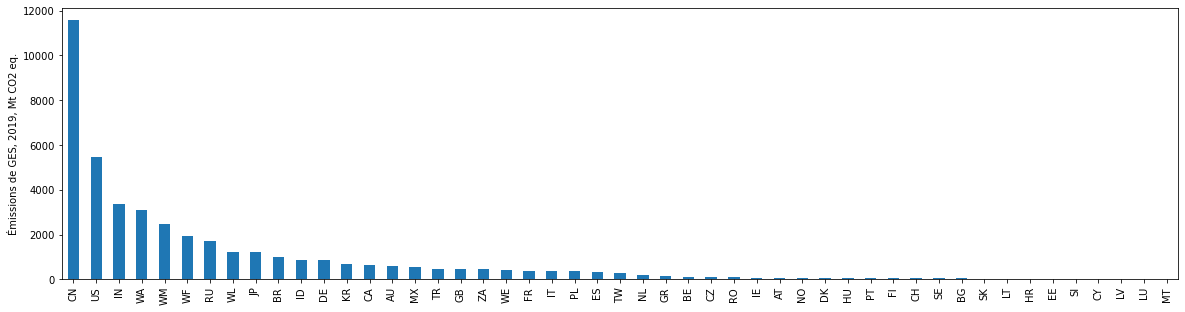

In [39]:
emissions_GES_inventaire.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), ylabel='Émissions de GES, 2019, Mt CO2 eq.')

Un peu mieux. Ensuite il faut y ajouter les émissions directes de la consommation finale (ce que les ménages ou l'administration émettent via l'utilisation de voitures, chauffage, ...). Ces valeurs sont contenues dans `F_Y`.

In [40]:
emissions_GES_finales = GWP_to_use.dot(io.satellite.F_Y).groupby('region').sum()*1e-9

In [41]:
emissions_GES_finales['FR']

72.202122172689

In [42]:
(emissions_GES_inventaire + emissions_GES_finales)['FR']

459.420716121546

Voilà qui est plus en accord avec les estimations du SDES.

### Empreinte carbone
On appelle l'empreinte carbone la somme des émissions liées à la consommation finale, en gaz à effet de serre ("carbone" étant un abus de langage). C'est `D_cba` qui nous donne les valeurs.

Ce calcul s'appuie sur l'inverse de Leontief, qui permet de remonter les chaînes de valeur jusqu'à la production primaire pour chaque secteur, y compris via les échanges entre pays.

Formellement, le calcul est 

$$D_{cba} = S L \hat{y}$$

Même principe qu'au-dessus pour le calcul en GES.

In [43]:
io.A.shape

(7987, 7987)

In [44]:
io.Z.shape

(7987, 7987)

In [45]:
io.Y.shape

(7987, 343)

In [46]:
io.satellite.S.loc['CO2 - combustion - air']

region  sector                                             
AT      Cultivation of paddy rice                                   0.000000
        Cultivation of wheat                                   631799.002656
        Cultivation of cereal grains nec                       261081.166377
        Cultivation of vegetables, fruit, nuts                  63322.120128
        Cultivation of oil seeds                               279931.683289
                                                                   ...      
WM      Activities of membership organisation n.e.c. (91)       12239.478385
        Recreational, cultural and sporting activities (92)      9705.666463
        Other service activities (93)                           12373.155200
        Private households with employed persons (95)            9972.086685
        Extra-territorial organizations and bodies                  0.000000
Name: CO2 - combustion - air, Length: 7987, dtype: float64

In [47]:
io.satellite.D_cba_reg.loc['Domestic Extraction Used - Metal Ores - Iron ores']

AT    4.872317e+03
BE    8.331770e+03
BG    1.445816e+03
CY    3.312127e+02
CZ    3.368044e+03
DE    3.617005e+04
DK    2.739247e+03
EE    5.699871e+02
ES    1.109443e+04
FI    3.106114e+03
FR    2.235004e+04
GR    2.772152e+03
HR    1.089652e+03
HU    2.901619e+03
IE    4.479551e+03
IT    1.644203e+04
LT    1.080058e+03
LU    9.514819e+02
LV    6.269426e+02
MT    3.002555e+02
NL    9.321190e+03
PL    8.358342e+03
PT    2.712177e+03
RO    5.012078e+03
SE    1.449960e+04
SI    9.703629e+02
SK    1.644951e+03
GB    2.229291e+04
US    2.143011e+05
JP    9.204393e+04
CN    1.797107e+06
CA    1.817849e+04
KR    5.596575e+04
BR    3.230129e+04
IN    2.722086e+05
MX    2.467878e+04
RU    9.668354e+04
AU    8.791044e+04
CH    4.199067e+03
TR    1.562602e+04
TW    3.817936e+04
NO    4.626137e+03
ID    2.775667e+04
ZA    1.700861e+04
WA    2.023578e+05
WL    6.815642e+04
WE    1.002207e+05
WF    6.161158e+04
WM    1.312007e+05
Name: Domestic Extraction Used - Metal Ores - Iron ores, dtype: float

In [48]:
io.satellite.unit.loc['Domestic Extraction Used - Metal Ores - Iron ores']

unit    kt
Name: Domestic Extraction Used - Metal Ores - Iron ores, dtype: object

In [49]:
io.satellite.D_cba_reg.loc['CO2 - combustion - air']

AT    8.225680e+10
BE    1.277133e+11
BG    2.890657e+10
CY    8.601214e+09
CZ    1.002147e+11
DE    8.588997e+11
DK    6.310997e+10
EE    1.322101e+10
ES    2.646886e+11
FI    5.276715e+10
FR    4.247486e+11
GR    1.274647e+11
HR    1.878008e+10
HU    5.895130e+10
IE    6.636606e+10
IT    4.177419e+11
LT    1.835798e+10
LU    1.160118e+10
LV    1.126579e+10
MT    4.293782e+09
NL    1.714910e+11
PL    2.928821e+11
PT    5.369725e+10
RO    7.874922e+10
SE    6.348803e+10
SI    1.589365e+10
SK    3.880829e+10
GB    5.235649e+11
US    5.728224e+12
JP    1.197775e+12
CN    9.041132e+12
CA    4.985667e+11
KR    6.629789e+11
BR    4.326622e+11
IN    2.305747e+12
MX    4.239427e+11
RU    1.194130e+12
AU    4.300208e+11
CH    8.072027e+10
TR    3.705994e+11
TW    2.138054e+11
NO    6.599054e+10
ID    5.441900e+11
ZA    2.633921e+11
WA    2.216898e+12
WL    8.015006e+11
WE    3.475141e+11
WF    9.501273e+11
WM    2.047598e+12
Name: CO2 - combustion - air, dtype: float64

In [94]:
(io.satellite.D_pba_reg.loc['CO2 - combustion - air'] - io.satellite.D_exp_reg.loc['CO2 - combustion - air']).sort_values(ascending=False)

CN    7.597447e+12
US    3.198669e+12
IN    1.841302e+12
WM    1.223005e+12
WA    9.424786e+11
RU    7.914391e+11
JP    6.769812e+11
WL    4.150432e+11
KR    4.009981e+11
DE    3.961641e+11
ID    3.536052e+11
WF    3.530533e+11
AU    2.822423e+11
MX    2.759234e+11
BR    2.508464e+11
TR    2.386883e+11
CA    2.232713e+11
WE    1.932201e+11
ZA    1.850244e+11
PL    1.824654e+11
GB    1.802407e+11
IT    1.790712e+11
FR    1.492290e+11
TW    1.275586e+11
ES    1.099983e+11
GR    8.376671e+10
CZ    5.609767e+10
NL    5.419721e+10
RO    3.209108e+10
AT    3.112035e+10
NO    3.014812e+10
BE    2.764592e+10
FI    2.544547e+10
PT    2.169464e+10
DK    1.972583e+10
HU    1.649933e+10
SE    1.509711e+10
CH    1.394163e+10
SK    1.160429e+10
BG    1.110694e+10
EE    7.789543e+09
IE    7.344738e+09
HR    6.085365e+09
SI    4.583316e+09
LV    3.883045e+09
LT    3.779588e+09
CY    2.600113e+09
LU    1.092708e+09
MT    4.017074e+08
Name: CO2 - combustion - air, dtype: float64

In [106]:
io.satellite.D_pba[('LU','Air transport (62)')].loc['CO2 - combustion - air']

4993751404.621436

In [100]:
io.satellite.D_imp['CH'].loc['CO2 - combustion - air'].sort_values(ascending=False)[:10]

sector
Manufacture of furniture; manufacturing n.e.c. (36)                                   5.270277e+09
Manufacture of medical, precision and optical instruments, watches and clocks (33)    4.017724e+09
Manufacture of machinery and equipment n.e.c. (29)                                    2.725098e+09
Air transport (62)                                                                    2.699358e+09
Petroleum Refinery                                                                    2.621137e+09
Health and social work (85)                                                           2.615949e+09
Manufacture of motor vehicles, trailers and semi-trailers (34)                        2.190977e+09
Chemicals nec                                                                         1.920186e+09
Manufacture of electrical machinery and apparatus n.e.c. (31)                         1.484910e+09
Sea and coastal water transport                                                       1.369973e+09
Nam

In [112]:
io.satellite.D_imp_reg.to_excel('flux_environnementaux_liés_aux_importations.xlsx')

In [97]:
(io.satellite.D_imp_reg.loc['CO2 - combustion - air']/io.satellite.D_pba_reg.loc['CO2 - combustion - air']).sort_values(ascending=False)

MT    3.304112
CH    1.838981
IE    1.410354
SE    1.278480
LU    1.174509
BE    1.023740
SK    0.937085
FR    0.882547
SI    0.879405
LT    0.853897
DK    0.850810
GB    0.802169
AT    0.751214
WF    0.734363
HR    0.718606
HU    0.710507
IT    0.692700
LV    0.674317
NL    0.621158
RO    0.564895
FI    0.560934
PT    0.554506
WA    0.535277
ES    0.500284
DE    0.500261
NO    0.494991
BG    0.434785
WL    0.421341
WE    0.417918
CY    0.413610
CZ    0.377220
EE    0.359653
KR    0.338657
JP    0.336087
US    0.334621
CA    0.318287
BR    0.293439
AU    0.279683
MX    0.272890
GR    0.269632
TR    0.252853
PL    0.235312
WM    0.234954
TW    0.223242
ID    0.208594
IN    0.124895
ZA    0.102190
RU    0.098350
CN    0.089024
Name: CO2 - combustion - air, dtype: float64

In [113]:
io.satellite.D_cba_reg.loc['Domestic Extraction Used - Metal Ores - Iron ores'].sort_values(ascending=False)

CN    1.737175e+06
IN    2.567948e+05
US    2.109848e+05
WA    1.973159e+05
WM    1.267142e+05
WE    9.655675e+04
JP    8.958056e+04
RU    8.743956e+04
AU    8.730464e+04
WL    6.591074e+04
WF    6.030829e+04
KR    5.461166e+04
TW    3.761425e+04
DE    3.525992e+04
BR    3.008941e+04
ID    2.713241e+04
MX    2.359014e+04
FR    2.176923e+04
GB    2.170454e+04
CA    1.771868e+04
ZA    1.734003e+04
IT    1.600709e+04
TR    1.529402e+04
SE    1.208157e+04
ES    1.089571e+04
NL    9.093390e+03
PL    8.163145e+03
BE    8.146301e+03
RO    4.876906e+03
AT    4.726970e+03
NO    4.517251e+03
IE    4.374304e+03
CH    4.087830e+03
CZ    3.282656e+03
FI    3.056439e+03
HU    2.808605e+03
DK    2.675354e+03
GR    2.646577e+03
PT    2.581408e+03
SK    1.594444e+03
BG    1.402741e+03
HR    1.034536e+03
LT    1.022778e+03
LU    9.378341e+02
SI    9.326956e+02
LV    6.027717e+02
EE    5.465625e+02
CY    3.155301e+02
MT    2.912066e+02
Name: Domestic Extraction Used - Metal Ores - Iron ores, dtype: float

In [127]:
# Émissions des secteurs économiques
io.satellite.F.loc['CO2 - combustion - air']

region  sector                                             
AT      Cultivation of paddy rice                              0.000000e+00
        Cultivation of wheat                                   2.621157e+08
        Cultivation of cereal grains nec                       2.353410e+08
        Cultivation of vegetables, fruit, nuts                 1.043426e+08
        Cultivation of oil seeds                               4.583117e+07
                                                                   ...     
WM      Activities of membership organisation n.e.c. (91)      2.484401e+08
        Recreational, cultural and sporting activities (92)    4.717884e+08
        Other service activities (93)                          3.388487e+08
        Private households with employed persons (95)          7.695058e+07
        Extra-territorial organizations and bodies             0.000000e+00
Name: CO2 - combustion - air, Length: 7987, dtype: float64

In [129]:
# Production totale
io.x

indout
region sector                                                          
AT     Cultivation of paddy rice                               0.000000
       Cultivation of wheat                                  378.272102
       Cultivation of cereal grains nec                      894.025172
       Cultivation of vegetables, fruit, nuts               1665.261806
       Cultivation of oil seeds                              175.855935
...                                                                 ...
WM     Activities of membership organisation n.e.c. (91)   22761.213885
       Recreational, cultural and sporting activities ...  54138.374081
       Other service activities (93)                       31620.402676
       Private households with employed persons (95)        7096.152986
       Extra-territorial organizations and bodies              0.000000

[7987 rows x 1 columns]

In [137]:
# Émissions directes
io.satellite.F_Y.groupby('region', axis=1).sum().loc['CO2 - combustion - air']

region
AT    1.518687e+10
AU    4.346690e+10
BE    2.772834e+10
BG    4.615637e+09
BR    7.691500e+10
CA    1.130562e+11
CH    1.587487e+10
CN    5.900148e+11
CY    1.604244e+09
CZ    1.155004e+10
DE    1.623860e+11
DK    8.541228e+09
EE    7.458823e+08
ES    6.364519e+10
FI    4.746364e+09
FR    7.499302e+10
GB    1.188646e+11
GR    1.247643e+10
HR    3.178123e+09
HU    1.812437e+10
ID    8.077908e+10
IE    9.232378e+09
IN    2.100789e+11
IT    6.912811e+10
JP    2.183064e+11
KR    6.625287e+10
LT    6.746674e+09
LU    1.412304e+09
LV    1.582784e+09
MT    8.250986e+07
MX    5.258857e+10
NL    2.964787e+10
NO    4.365216e+09
PL    5.184273e+10
PT    1.229119e+10
RO    2.024578e+10
RU    2.565064e+11
SE    7.938940e+09
SI    3.319164e+09
SK    4.813027e+09
TR    4.221383e+10
TW    2.703044e+10
US    1.362642e+12
WA    3.233873e+11
WE    3.389020e+10
WF    2.761350e+11
WL    1.345585e+11
WM    3.294332e+11
ZA    4.629606e+10
Name: CO2 - combustion - air, dtype: float64

In [146]:
io.satellite.F_Y.groupby('region', axis=1).sum().loc['CO2 - combustion - air']/io.population.T['population']

AT    1695.909016
AU    1724.671794
BE    2403.010811
BG     659.376742
BR     364.439705
CA    3022.005371
CH    1847.849333
CN     411.508849
CY    1337.984607
CZ    1080.554036
DE    1944.346577
DK    1479.769184
EE     562.505523
ES    1361.773101
FI     857.983429
FR    1151.435959
GB    1760.174365
GR    1191.294669
HR     769.521253
HU    1871.385494
ID     298.489732
IE    1891.105639
IN     153.744219
IT    1141.669872
JP    1720.845142
KR    1293.369812
LT    2444.446965
LU    2292.701331
LV     829.986277
MT     187.522407
MX     412.213652
NL    1734.097991
NO     811.529241
PL    1368.315282
PT    1201.954550
RO    1045.483086
RU    1758.435132
SE     791.046209
SI    1596.519388
SK     881.991304
TR     505.979027
TW    1136.974853
US    4140.949636
WA     302.150674
WE     480.262437
WF     220.995367
WL     434.592420
WM    1727.530692
ZA     790.601801
dtype: float64

In [50]:
# Somme empreinte indirecte + émissions directes
empreinte_totale = io.satellite.D_cba_cap.loc['CO2 - combustion - air'] + io.satellite.F_Y.groupby('region', axis=1).sum().loc['CO2 - combustion - air']/io.population.T['population']

In [51]:
# Indicateur pour les gaz à effet de serre (agrège CO2, CH4, CH4, ...)
indicateur = 'Climate change midpoint | ILCD recommended CF | Global warming potential 100 years'

In [55]:
# Gaz à effet de serre par personne
empreinte_par_personne = (io.impacts.D_cba_cap.loc[indicateur])
# + \
# io.satellite.F_Y.groupby('region', axis=1).sum().loc['CO2 - combustion - air']/io.population.T['population'])

<AxesSubplot:>

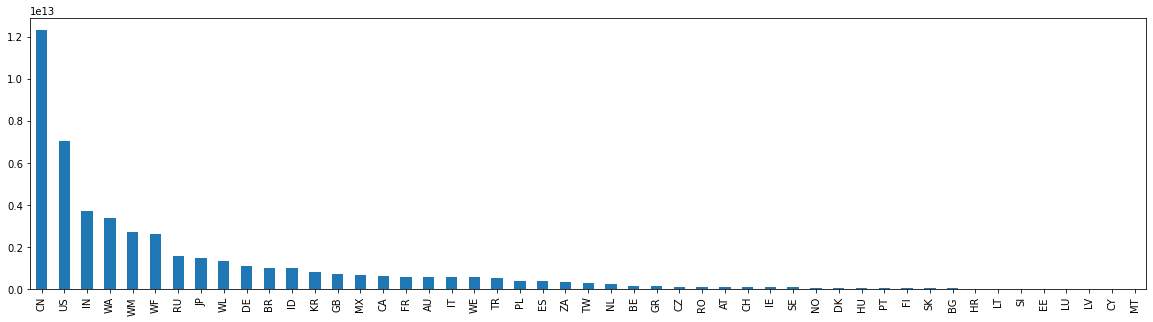

In [60]:
io.impacts.D_cba_reg.loc[indicateur].sort_values(ascending=False).plot.bar(figsize=(20,5))

In [57]:
empreinte_par_personne.sort_values(ascending=False)

LU    28717.128796
AU    22922.585330
US    21342.043484
IE    20325.562075
CA    16866.224093
KR    16495.535433
NO    15862.586125
BE    14910.500190
GR    14892.753572
MT    14297.621669
DK    14208.616518
WM    14142.875295
NL    13898.351319
EE    13822.394784
FI    13665.409633
DE    13114.464737
CH    12385.746752
AT    12082.601733
CZ    12041.467063
TW    11857.021051
JP    11589.630632
RU    10972.878900
PL    10920.223827
GB    10854.445458
SI    10635.221314
SK     9960.623487
IT     9377.322492
CY     9370.021752
LT     9317.579951
FR     9238.725140
SE     9124.441193
CN     8570.494682
LV     8488.991884
HU     8347.804023
ES     8025.736964
WE     7943.784905
PT     7718.692812
HR     6712.757390
TR     6579.758443
BG     6316.965063
RO     6101.106334
ZA     5819.996438
MX     5219.153698
BR     4889.273113
WL     4405.183200
ID     3707.784194
WA     3142.888773
IN     2736.328024
WF     2082.906929
Name: Climate change midpoint | ILCD recommended CF | Global warming 

<AxesSubplot:>

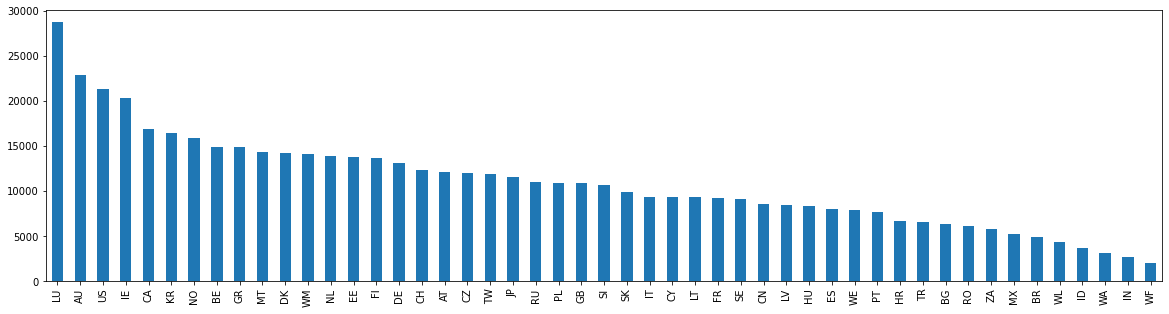

In [56]:
empreinte_par_personne.sort_values(ascending=False).plot.bar(figsize=(20,5))

In [178]:
empreinte_fer = io.satellite.D_cba_cap.loc['Domestic Extraction Used - Metal Ores - Iron ores'] + \
io.satellite.F_Y.groupby('region', axis=1).sum().loc['Domestic Extraction Used - Metal Ores - Iron ores']/io.population.T['population']

In [183]:
io.satellite.D_cba.loc['Domestic Extraction Used - Metal Ores - Iron ores']['SE'].sort_values(ascending=False)

sector
Construction (45)                                                                    4.215397e+03
Mining of iron ores                                                                  2.081412e+03
Manufacture of machinery and equipment n.e.c. (29)                                   7.799519e+02
Supporting and auxiliary transport activities; activities of travel agencies (63)    5.809905e+02
Manufacture of motor vehicles, trailers and semi-trailers (34)                       4.419427e+02
                                                                                         ...     
Production of electricity by tide, wave, ocean                                       5.647698e-09
Re-processing of secondary preciuos metals into new preciuos metals                  7.346377e-11
Manure treatment (conventional), storage and land application                        0.000000e+00
Manure treatment (biogas), storage and land application                              0.000000e+00
Extra-territo

<AxesSubplot:>

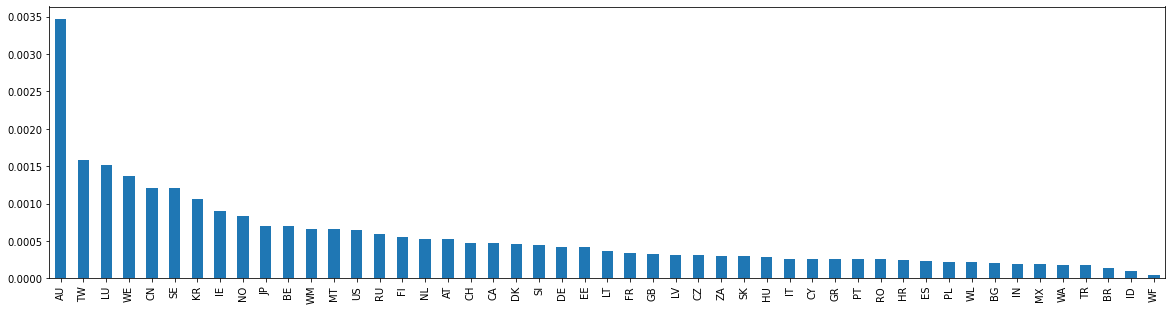

In [179]:
empreinte_fer.sort_values(ascending=False).plot.bar(figsize=(20,5))

<AxesSubplot:ylabel='Émissions de GES, 2019, Mt CO2 eq.'>

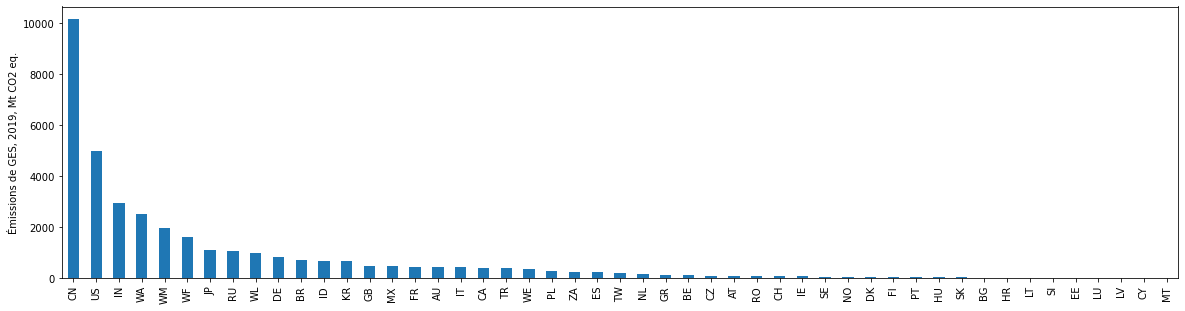

In [64]:
emissions_GES_empreinte = GWP_to_use.dot(io.satellite.D_cba_reg)*1e-9

emissions_GES_empreinte.sort_values(ascending=False).plot(kind='bar', figsize=(20,5), ylabel='Émissions de GES, 2019, Mt CO2 eq.')

Empreinte carbone de la France en 2019, en Mt CO2 eq.

In [65]:
(emissions_GES_empreinte + emissions_GES_finales)['FR']

532.2910964885685

### Comparaison émissions territoriale/empreinte

In [66]:
comp = pd.concat([(emissions_GES_inventaire + emissions_GES_finales),
           (emissions_GES_empreinte + emissions_GES_finales)],
          keys=('Inventaire national','Empreinte'),
          axis=1).sort_values(by='Empreinte')

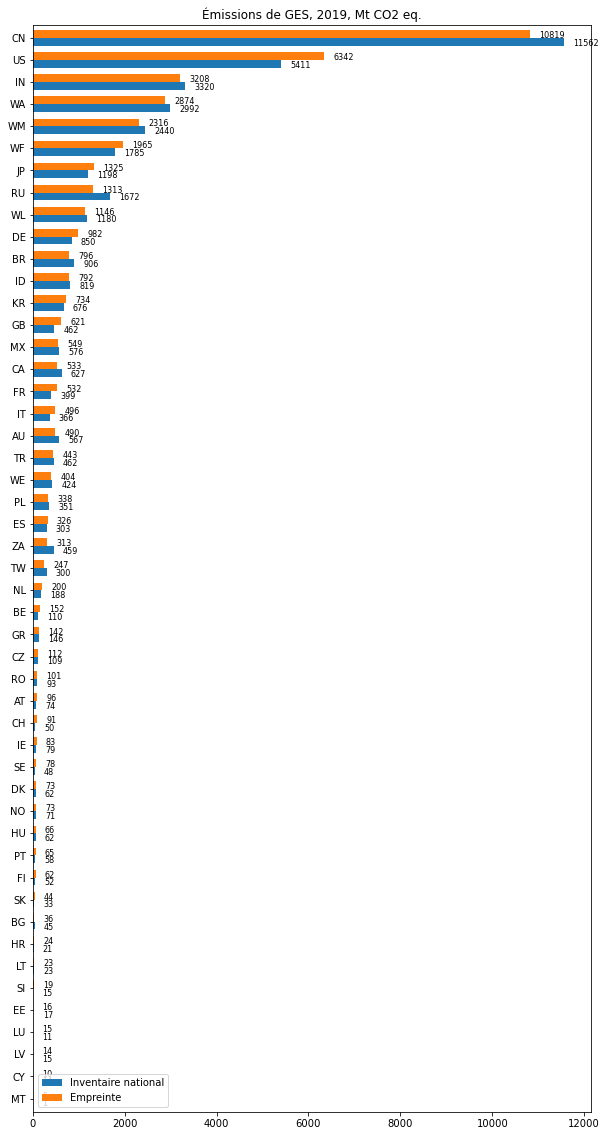

In [67]:
ax = comp.plot(kind='barh', figsize=(10,20), title='Émissions de GES, 2019, Mt CO2 eq.', width=0.7)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width()+200, p.get_y()), fontsize=8)

## Idées d'exercices

Groupe S17: Questions "données"
- Depuis quels principaux pays la France importe-t-elle son empreinte carbone ?
- Quels secteurs de l'économie importent le plus ? le moins ?
- Quels sont les postes principaux d'émissions des ménages ?

Groupe S18: Questions "méthodes"
- D'autres sources d'empreinte existent, notamment: 
    - Eora database https://worldmrio.com/
    - Global Carbon Project https://doi.org/10.5194/essd-12-3269-2020
    - Calculs du SDES https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-12/datalab_81_chiffres_cles_du_climat_edition_2021.pdf?page=44
    ...en quoi ces sources diffèrent-elles ?
- Quels sont les intérêts de la méthode "inventaire national", et de la méthode "empreinte carbone" ? Pouvez-vous imaginer d'autres méthodes de comptabilité "hybrides" ?

In [259]:
GWP_to_use.dot(io.satellite.F_Y['LU']).sum()*1e-9

1.4229775958215252

In [261]:
GWP_to_use.dot(io.satellite.D_imp_reg['LU'])*1e-9

12.587882492404653

In [262]:
GWP_to_use.dot(io.satellite.D_exp_reg['LU'])*1e-9

7.953966457571323

In [263]:
GWP_to_use.dot(io.satellite.D_pba_reg['LU'])*1e-9

9.286355982051637

In [264]:
GWP_to_use.dot(io.satellite.D_cba_reg['LU'])*1e-9

13.920272016894542

In [265]:
GWP_to_use.dot(io.satellite.D_cba_reg['LU'])*1e-9 + GWP_to_use.dot(io.satellite.F_Y['LU']).sum()*1e-9

15.343249612716066

In [252]:
GWP_to_use.mul(io.satellite.D_pba_reg['LU']).sort_values(ascending=False).cumsum()

stressor
CO2 - combustion - air                                   8.000164e+09
CH4 - agriculture - air                                  8.644078e+09
CO2 - non combustion - Cement production - air           8.960761e+09
N2O - agriculture - air                                  9.274570e+09
CH4 - combustion - air                                   9.286356e+09
                                                             ...     
Unused Domestic Extraction - Primary Crops - Figs        9.286356e+09
Unused Domestic Extraction - Primary Crops - Dates       9.286356e+09
Unused Domestic Extraction - Primary Crops - Currants    9.286356e+09
Unused Domestic Extraction - Primary Crops - Cherries    9.286356e+09
Taxes less subsidies on products purchased: Total        9.286356e+09
Length: 1113, dtype: float64

In [250]:
solde_GES = (emissions_GES_empreinte - emissions_GES_inventaire)/emissions_GES_empreinte

<AxesSubplot:>

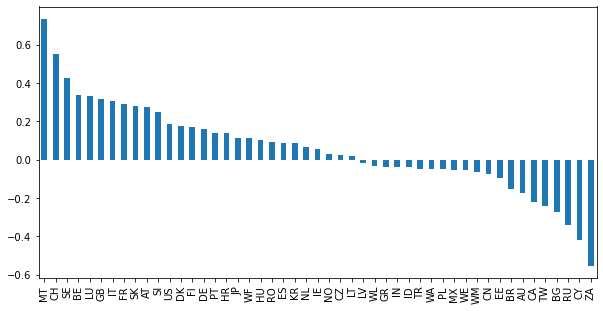

In [251]:
solde_GES.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))